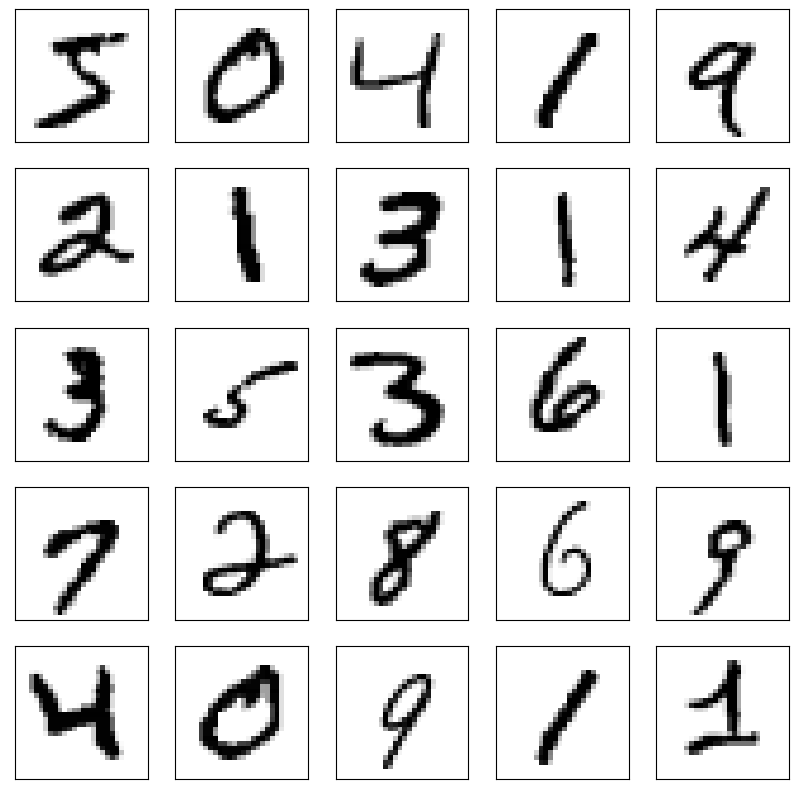

In [21]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import load_model
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import random
# image pre-processing
from scipy import ndimage # image augmentation
from skimage.transform import resize # image augmentation - resize

data_train, data_test = tf.keras.datasets.mnist.load_data()
(image_train, labels_train) = data_train
(image_test, labels_test) = data_test

# 클래스 이름 정의 (MNIST 데이터셋에는 클래스 이름이 없으므로 생략)
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

# 이미지 시각화
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image_train[i], cmap=plt.cm.binary)
plt.show()

In [22]:
# 아래코드 참고, resize 기능은 자체 구현
# https://github.com/deeplearningzerotoall/TensorFlow/blob/master/tf_2.x/lab-11-5-mnist-cnn-best-keras-eager.ipynb
# 이미지, 라벨, augmentation 배율(2 이상)
def data_augmentation(images_t, labels_t, aug_scale):
    # augmentation 적용할 빈 리스트 정의
    aug_images, aug_labels = [], []
    
    # tqdm으로 진행률 표시
    for x, y in zip(tqdm(images_t), labels_t):
        # 기존 이미지,라벨 추가
        aug_images.append(x)
        aug_labels.append(y)
        
        # augmenatation 배율
        if aug_scale < 2 :
            pass
        
        # 각 이미지마다 정의된 만큼 augmentation 반복, 원본데이터 제외하므로 1 감소
        for _ in range(aug_scale - 1):
            # 이미지 크기 변경 (0,2,4 만큼 H,W 크기를 줄인 후 padding 적용하여 기존의 28x28크기로 만듬)
            padding_t = random.choice([0,0,1,1,2])
            if padding_t != 0 : #0이면 연산 x
                x = np.pad(
                    resize(x, (28 - (padding_t * 2), 28 - (padding_t * 2))),
                    [(padding_t, padding_t), (padding_t, padding_t)],
                    mode='constant', # 아래에 설정된 값으로 채움
                    constant_values=0, # 0(white)로 채움
                )
            
            # -15 ~ 15 rotation, 빈배경(0) 적용
            angle = np.random.randint(-15, 15, 1)
            rot_img = ndimage.rotate(x, angle[0], reshape=False, cval=0)
            
            # -3 ~ 3 픽셀 가로세로 shift, resize 적용되었을 때 padding만큼 더 이동, 빈배경(0) 적용
            #shift_pixel = 1 if padding_t == 0 else padding_t
            shift = np.random.randint((-3 - padding_t), (3 + padding_t), 2)
            shift_img = ndimage.shift(rot_img, shift, cval=0)            
            
            # augmentation 적용된 이미지,라벨 추가
            aug_images.append(shift_img)
            aug_labels.append(y)
            
    # numpy 자료형 변환 및 리턴
    return np.array(aug_images), np.array(aug_labels)



# Augmentation 배율
augmentation_scale = 10

In [23]:
print(f"현재 학습 데이터 갯수 : \ndata : {len(image_train)}개 / label : {len(labels_train)}개")
print(f"\n현재 테스트 데이터 갯수 : \ndata : {len(image_test)}개 / label : {len(labels_test)}개")
ds_tr_size, ds_ts_size = len(labels_train), len(labels_test)

현재 학습 데이터 갯수 : 
data : 60000개 / label : 60000개

현재 테스트 데이터 갯수 : 
data : 10000개 / label : 10000개


In [24]:
# dataset image normalization
image_train, image_test = image_train / 255.0, image_test / 255.0

In [25]:
image_train, labels_train = data_augmentation(image_train, labels_train, augmentation_scale)
image_test, labels_test = data_augmentation(image_test, labels_test, augmentation_scale)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:18<00:00, 548.27it/s]


In [26]:
print(f"현재 학습 데이터 갯수 : \ndata : {len(image_train)}개 / label : {len(labels_train)}개")
print(f"\n현재 테스트 데이터 갯수 : \ndata : {len(image_test)}개 / label : {len(labels_test)}개")

현재 학습 데이터 갯수 : 
data : 600000개 / label : 600000개

현재 테스트 데이터 갯수 : 
data : 100000개 / label : 100000개


In [27]:
print(f"학습 데이터셋 Aumentation 적용 배율 : {(len(labels_train)/ds_tr_size):g}배")
print(f"테스트 데이터셋 Augmentation 적용 배율 : {(len(labels_test)/ds_ts_size):g}배")

학습 데이터셋 Aumentation 적용 배율 : 10배
테스트 데이터셋 Augmentation 적용 배율 : 10배


In [28]:
def show_imgs(list_t, label_t, plt_title=""):
    # subplot으로 한줄에 10개씩 표시
    
    # 가로 줄 갯수, 매 10개마다 추가ㅌㅌㅌ
    row = len(list_t) // 10
    # 10개 단위로 빼고 남을 경우 한줄 더 추가
    if len(list_t) % 10 != 0:
        row += 1

    fig = plt.figure(figsize=(15, row*1.5))
    
    # 제목 지정 시 출력
    if plt_title != "" :
        fig.suptitle(plt_title)

    for i in range(len(list_t)) :
        ax = fig.add_subplot(row, 10, i+1, xticks=[], yticks=[])
        ax.set_title(label_t[i])
        ax.imshow(list_t[i].reshape(28,28), cmap = plt.cm.binary)

    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, hspace=0.1, wspace=0.5)
    plt.show()

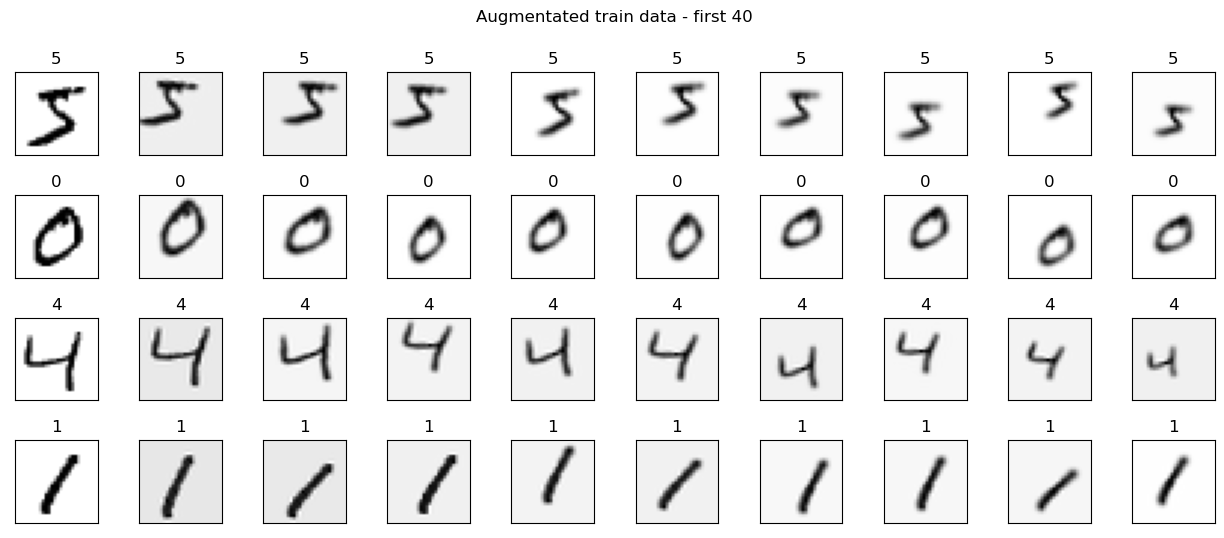

In [29]:
show_img_size = 40
show_imgs(image_train[:show_img_size], labels_train[:show_img_size], f"Augmentated train data - first {show_img_size}")

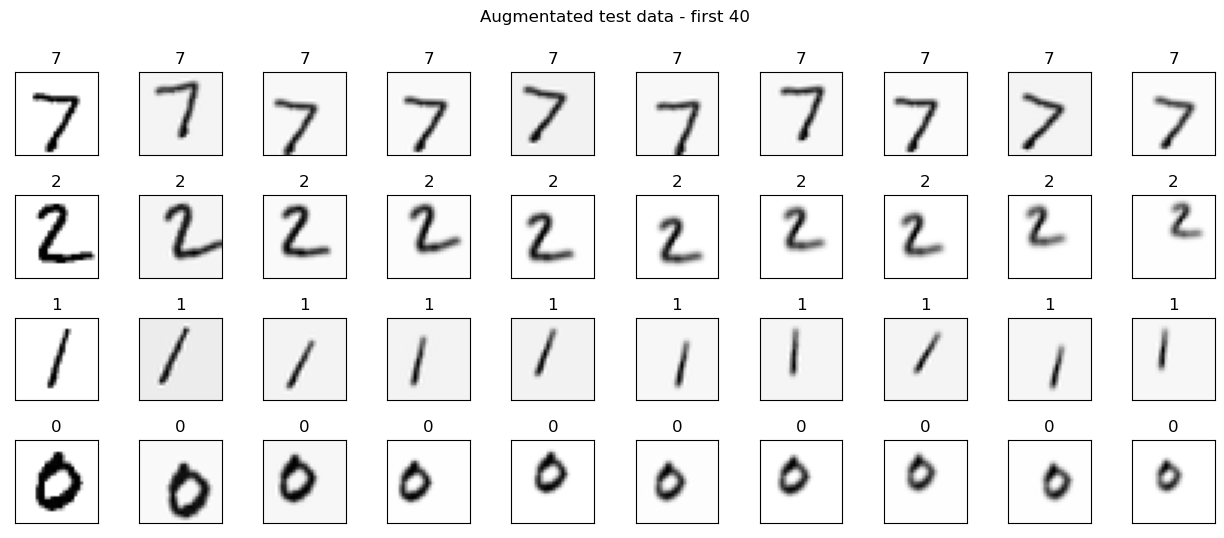

In [30]:
show_imgs(image_test[:show_img_size], labels_test[:show_img_size], f"Augmentated test data - first {show_img_size}")

In [31]:
model=keras.models.Sequential([        
    layers.Conv2D(32,(3,3), padding ='same', activation='relu',input_shape =(28,28,1)),
    layers.MaxPooling2D((2,2),strides=2),
    layers.Conv2D(64,(3,3), padding ='same', activation='relu'),
    layers.MaxPooling2D((2,2),strides=2),
    layers.Flatten(),
    #layers.Dense(128,activation = 'relu',input_shape = (28*28,) ),
    layers.Dense(128,activation = 'relu' ),
    layers.Dropout(0.2),
    layers.Dense(10,activation = 'softmax')
])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 421,642 (1.61 MB)

 Trainable params: 421,642 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# Epoch 지정
epoch_t = 50

# 배치크기 지정
bs_t = 100

model.fit(image_train,
                        labels_train,
                        epochs=epoch_t,
                        batch_size=bs_t,
                        validation_data=(image_test, labels_test),
                        verbose=1,
                       )

Epoch 1/50
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step - accuracy: 0.8767 - loss: 0.3846 - val_accuracy: 0.9797 - val_loss: 0.0644
Epoch 2/50
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - accuracy: 0.9765 - loss: 0.0761 - val_accuracy: 0.9851 - val_loss: 0.0456
Epoch 3/50
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - accuracy: 0.9845 - loss: 0.0505 - val_accuracy: 0.9854 - val_loss: 0.0469
Epoch 4/50
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - accuracy: 0.9874 - loss: 0.0399 - val_accuracy: 0.9889 - val_loss: 0.0348
Epoch 5/50
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - accuracy: 0.9896 - loss: 0.0323 - val_accuracy: 0.9878 - val_loss: 0.0410
Epoch 6/50
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - accuracy: 0.9905 - loss: 0.0286 - val_accuracy: 0.9893 - val_loss: 0.0364
Epoch 7/50
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - accuracy: 0.9921 - loss: 0.0245 - val_accuracy: 0.9901 - val_loss: 0.0353
Epoch 8/50
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - accuracy: 0.9929 - loss: 0

6000/6000 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - accuracy: 0.9977 - loss: 0.0076 - val_accuracy: 0.9891 - val_loss: 0.0663


In [33]:
# 기존 학습 및 테스트 데이터로 평가
print(model.evaluate(image_train, labels_train))
print(model.evaluate(image_test, labels_test))

18750/18750 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step - accuracy: 0.9992 - loss: 0.0026
[0.0026627799961715937, 0.9991516470909119]
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9862 - loss: 0.0873
[0.06627865880727768, 0.989080011844635]


In [34]:
model.save('seungchan02020.keras')

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.models import load_model
import cv2

# 모델 로드
model = load_model('seungchan02020.keras')

image_folder = "C:\\Users\\CHANG\\Desktop\\computervision-main\\team1"

# 모델 컴파일
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 이미지 전처리 함수 정의 (멀티스케일 엣지 검출 적용)
def preprocess_image(img):
    # 이미지 크기를 (28, 28)로 변경하고 Grayscale로 변환
    img = img.resize((28, 28))
    img_gray = img.convert('L')
    
    # 이미지를 배열로 변환
    img_array = np.array(img_gray)
    
    # 멀티스케일 엣지 검출을 위한 엣지 맵 생성
    edges = np.zeros_like(img_array)
    
    # 다양한 스케일의 엣지 검출을 위해 여러 번의 Canny 엣지 검출을 수행
    for scale in range(1, 4):
        img_blur = cv2.GaussianBlur(img_array, (5, 5), 0)  # 가우시안 블러링 적용
        edges += cv2.Canny(img_blur, 30 * scale, 100 * scale)  # 다양한 스케일로 Canny 엣지 검출
        
    # 이미지를 0~1 사이의 값으로 스케일 조정
    img_array = edges / np.max(edges)
    
    # 차원 확장
    img_array = np.expand_dims(img_array, axis=0) 
    
    return img_array

# 이미지 예측 함수 정의
def predict_images(image_folder):
    predictions = []
    correct_predictions = 0
    total_images = 0
    for filename in os.listdir(image_folder):
        img_path = os.path.join(image_folder, filename)
        img = image.load_img(img_path, target_size=(28, 28))
        img_array = preprocess_image(img)
        prediction = model.predict(img_array)
        predicted_digit = np.argmax(prediction)
        predictions.append((img_path, predicted_digit))
        
        # 테스트 데이터 정확도 계산
        total_images += 1
        if predicted_digit == int(filename[0]):  # 이미지 파일명의 첫 번째 문자는 실제 레이블을 나타냄
            correct_predictions += 1
    
    accuracy = correct_predictions / total_images
    print("Accuracy:", accuracy)
    
    return predictions

# 전체 데이터 폴더 경로
base_folder = "C:\\Users\\CHANG\\Desktop\\computervision-main"

# 전체 정확도 계산을 위한 변수 초기화
total_correct_predictions = 0
total_images = 0

# 각 폴더에 대해 예측 수행 및 정확도 계산
for folder_num in range(1, 26):
    image_folder = os.path.join(base_folder, f"team{folder_num}")
    
    # 이미지 폴더가 존재하는지 확인
    if os.path.exists(image_folder):
        predictions = predict_images(image_folder)
        correct_predictions = sum(1 for img_path, predicted_digit in predictions if predicted_digit == int(img_path.split("\\")[-1][0]))
        total_correct_predictions += correct_predictions
        total_images += len(predictions)
        print(f"Team {folder_num} Accuracy: {correct_predictions / len(predictions)}")

# 전체 정확도 계산
overall_accuracy = total_correct_predictions / total_images
print(f"\nOverall Accuracy: {overall_accuracy}")

# 이미지 예측 수행
predictions = predict_images(image_folder)

# 예측 결과 출력
for img_path, predicted_digit in predictions:
    print(f"Image: {img_path}, Predicted digit: {predicted_digit}")

# 예측 결과 시각화
plt.figure(figsize=(10, 10))
for i, (img_path, predicted_digit) in enumerate(predictions):
    img = image.load_img(img_path, target_size=(28, 28))
    plt.subplot(5, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Predicted: {predicted_digit}")
    plt.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Accuracy: 0.8
Team 1 Accuracy: 0.8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy: 0.7
Team 2 Accuracy: 0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━

C:\Users\CHANG\AppData\Local\Temp\ipykernel_31420\2775097634.py:36: RuntimeWarning: invalid value encountered in divide
  img_array = edges / np.max(edges)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Accuracy: 0.4
Team 4 Accuracy: 0.4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Accuracy: 0.9
Image: C:\Users\CHANG\Desktop\computervision-main\team5\0.png, Predicted digit: 0
Image: C:\Users\CHANG\Desktop\computervision-main\team5\1.png, Predicted digit: 1
Image: C:\Users\CHANG\Desktop\computervision-main\team5\2.png, Predicted digit: 2
Image: C:\Users\CHANG\Desktop\computervision-main\team5\3.png, Predicted digit: 3
Image: C:\Users\CHANG\Desktop\computervision-main\team5\4.png, Predicted digit: 2
Image: C:\Users\CHANG\Desktop\computervision-main\team5\5.png, Predicted digit: 5
Image: C:\Users\CHANG\Desktop\computervision-main\team5\6.png, Predicted digit: 6
Image: C:\Users\CHANG\Desktop\co

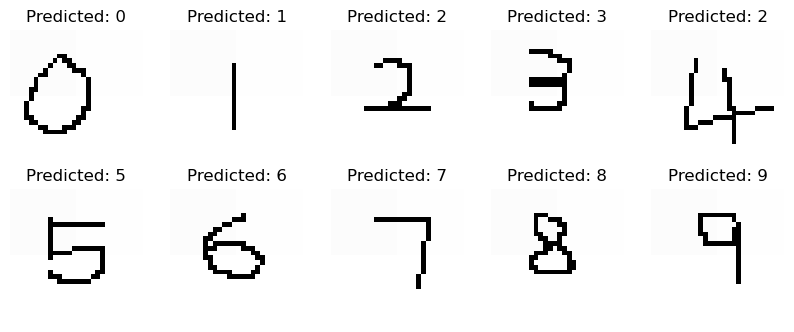

In [39]:
image_folder = "C:\\Users\\CHANG\\Desktop\\computervision-main\\team5"

predictions = predict_images(image_folder)

for img_path, predicted_digit in predictions:
    print(f"Image: {img_path}, Predicted digit: {predicted_digit}")

# 예측 결과 시각화
plt.figure(figsize=(10, 10))
for i, (img_path, predicted_digit) in enumerate(predictions):
    img = image.load_img(img_path, target_size=(28, 28))
    plt.subplot(5, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Predicted: {predicted_digit}")
    plt.axis('off')
plt.show()

